In [56]:
import pandas as pd
from pygam import LogisticGAM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
import os
import sys

# Define the current working directory
cwd = os.getcwd()

# load the data
data = pd.read_csv(cwd + '/health_data.csv')
data

,Unnamed: 0,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,0.0,18393.0,1,168.0,62.0,110.0,80.0,0,0,0,0,1,0
1,1,1.0,20228.0,0,156.0,85.0,140.0,90.0,2,0,0,0,1,1
2,2,2.0,18857.0,0,165.0,64.0,130.0,70.0,2,0,0,0,0,1
3,3,3.0,17623.0,1,169.0,82.0,150.0,100.0,0,0,0,0,1,1
4,4,4.0,17474.0,0,156.0,56.0,100.0,60.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,69995,99993.0,19240.0,1,168.0,76.0,120.0,80.0,0,0,1,0,1,0
69996,69996,99995.0,22601.0,0,158.0,126.0,140.0,90.0,1,1,0,0,1,1
69997,69997,99996.0,19066.0,1,183.0,105.0,180.0,90.0,2,0,0,1,0,1
69998,69998,99998.0,22431.0,0,163.0,72.0,135.0,80.0,0,1,0,0,0,1


In [57]:
# Create a working copy to avoid modifying the original data
df = data.copy()

# Define th list of categoriacl variables
categorical = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

# Convert inf to NaN, although according to the data description there are no Infs
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove NaNs, although according to the data description there are no NaNs
df.dropna(inplace=True)

# Drop the id column and -1
df.drop(['id', 'Unnamed: 0'], axis=1, inplace=True)

# Convert age in days
df['age'] = df['age']/365.25

# Filter for impossible values for height, weight, ap_hi, ap_lo
df = df[(df['height'] > 130) & (df['height'] < 220)]
df = df[(df['weight'] > 30) & (df['weight'] < 200)]
df = df[(df['ap_hi'] > 60) & (df['ap_hi'] < 240)]
df = df[(df['ap_lo'] > 40) & (df['ap_lo'] < 200)]
df = df[df['age'] <100]

# Add a new column for the BMI
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2

# Filter for reasonable values for BMI
df = df[(df['BMI'] > 6) & (df['BMI'] < 70)]

# Convert all categorical variables to strings,
# this will be undone at a later stage (remember to do it before the model)
df[categorical] = df[categorical].astype(str)

# Reset index for... resons?
df.reset_index(drop=True, inplace=True)

# Put the cardio column at the end
df = df[[c for c in df if c not in ['cardio']] + ['cardio']]

# Here's the resulting df
df

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI,cardio
0,50.357290,1,168.0,62.0,110.0,80.0,0,0,0,0,1,21.967120,0
1,55.381246,0,156.0,85.0,140.0,90.0,2,0,0,0,1,34.927679,1
2,51.627652,0,165.0,64.0,130.0,70.0,2,0,0,0,0,23.507805,1
3,48.249144,1,169.0,82.0,150.0,100.0,0,0,0,0,1,28.710479,1
4,47.841205,0,156.0,56.0,100.0,60.0,0,0,0,0,0,23.011177,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68636,52.676249,1,168.0,76.0,120.0,80.0,0,0,1,0,1,26.927438,0
68637,61.878166,0,158.0,126.0,140.0,90.0,1,1,0,0,1,50.472681,1
68638,52.199863,1,183.0,105.0,180.0,90.0,2,0,0,1,0,31.353579,1
68639,61.412731,0,163.0,72.0,135.0,80.0,0,1,0,0,0,27.099251,1


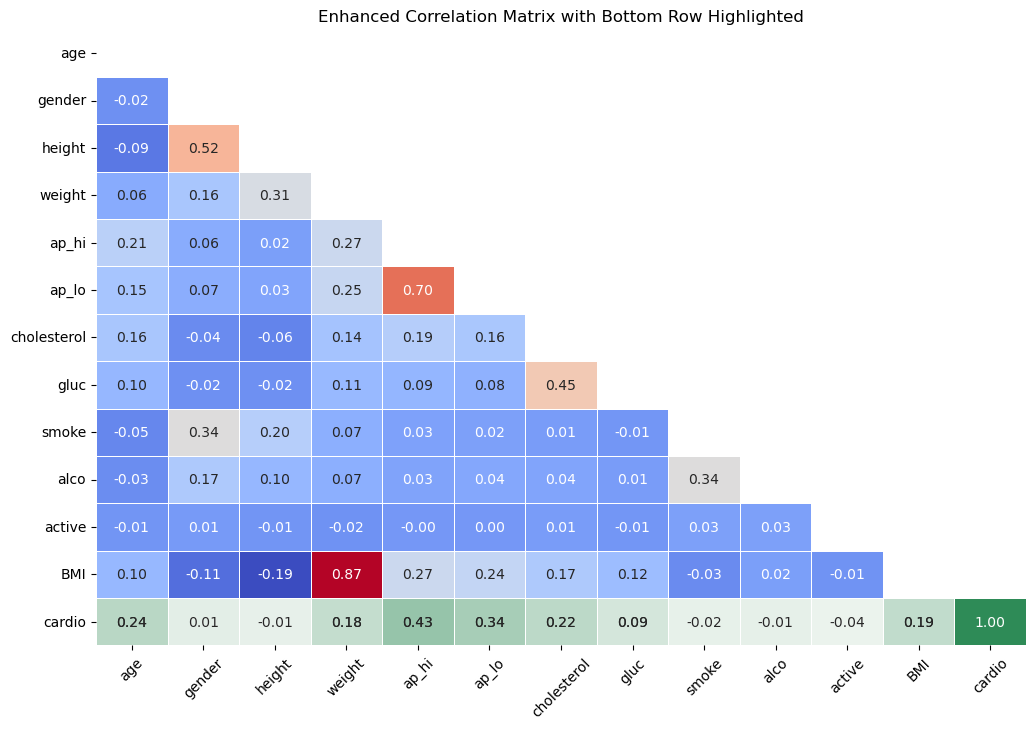

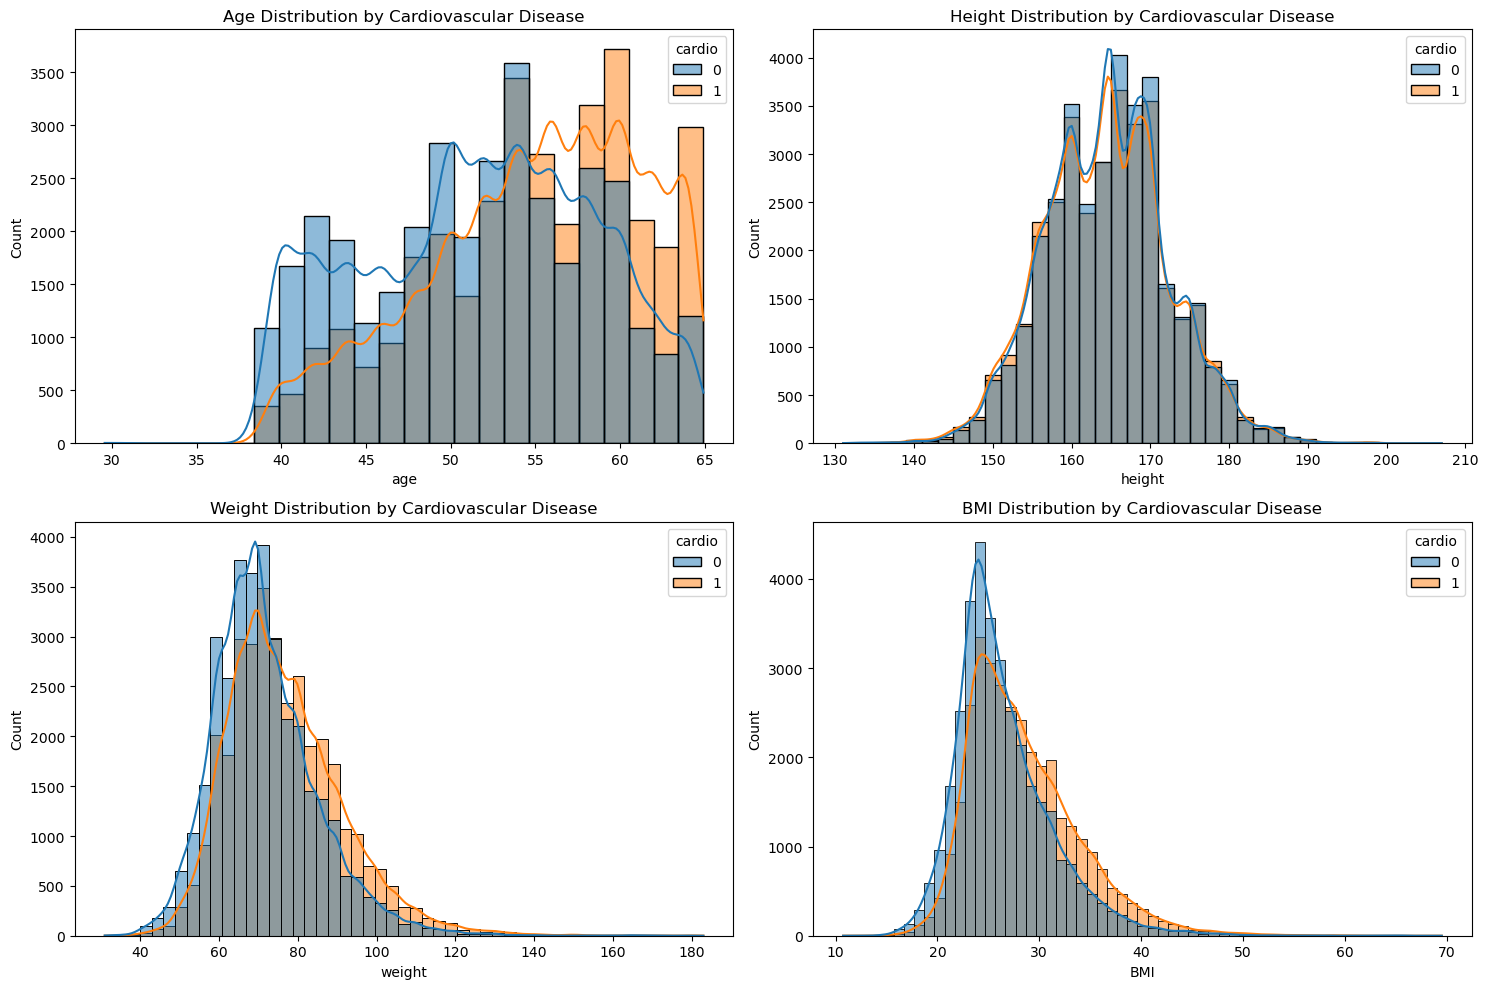

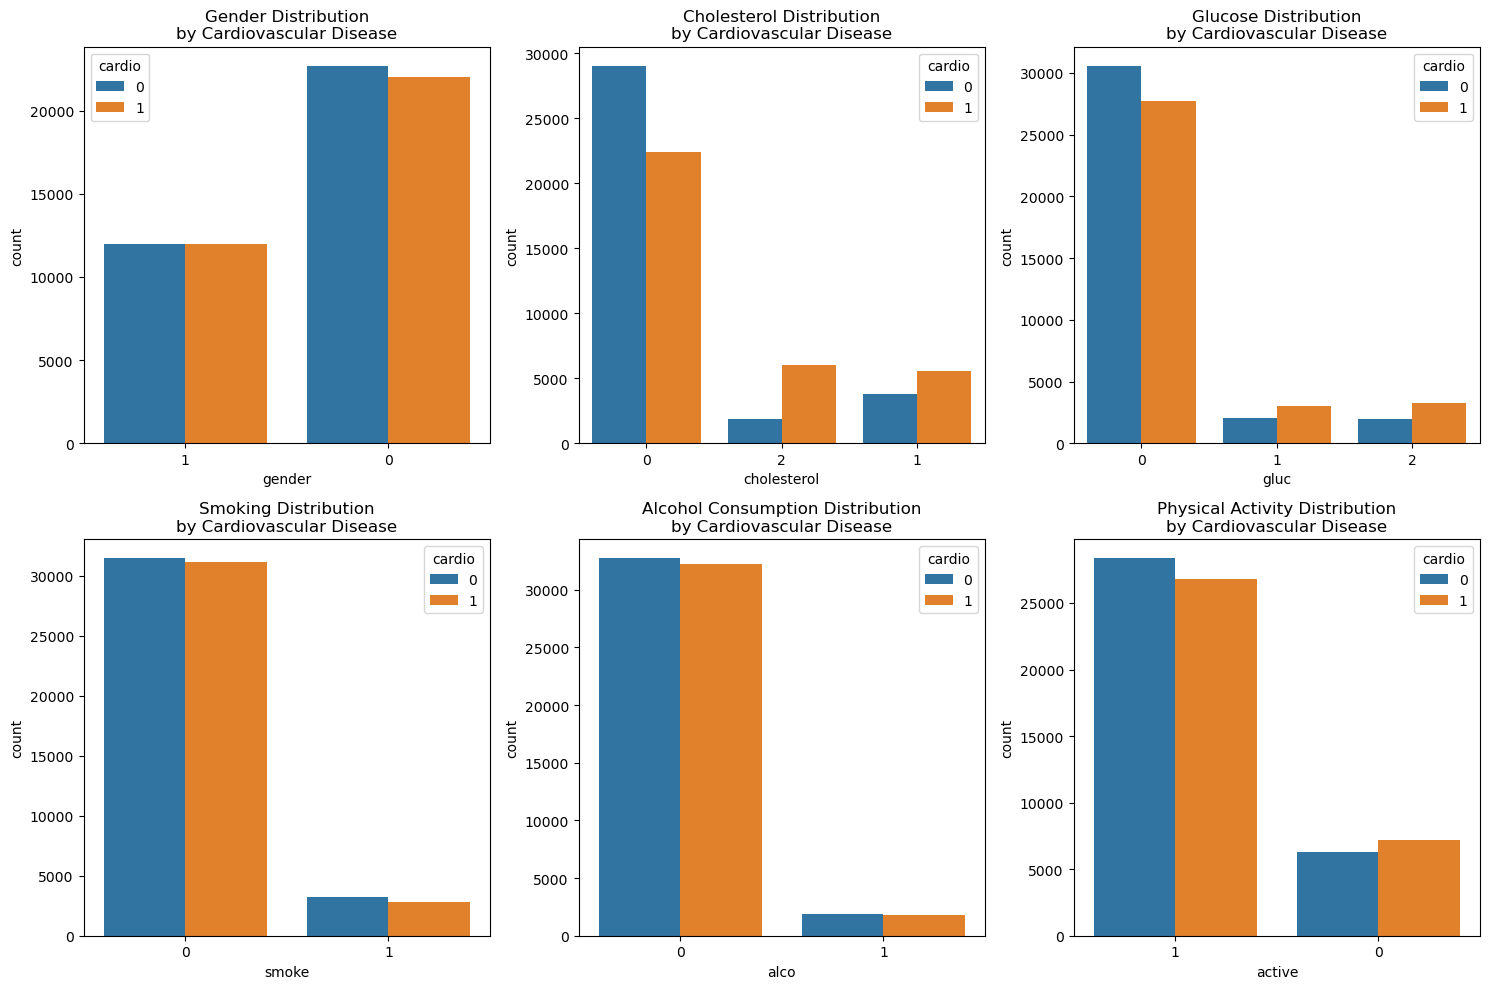

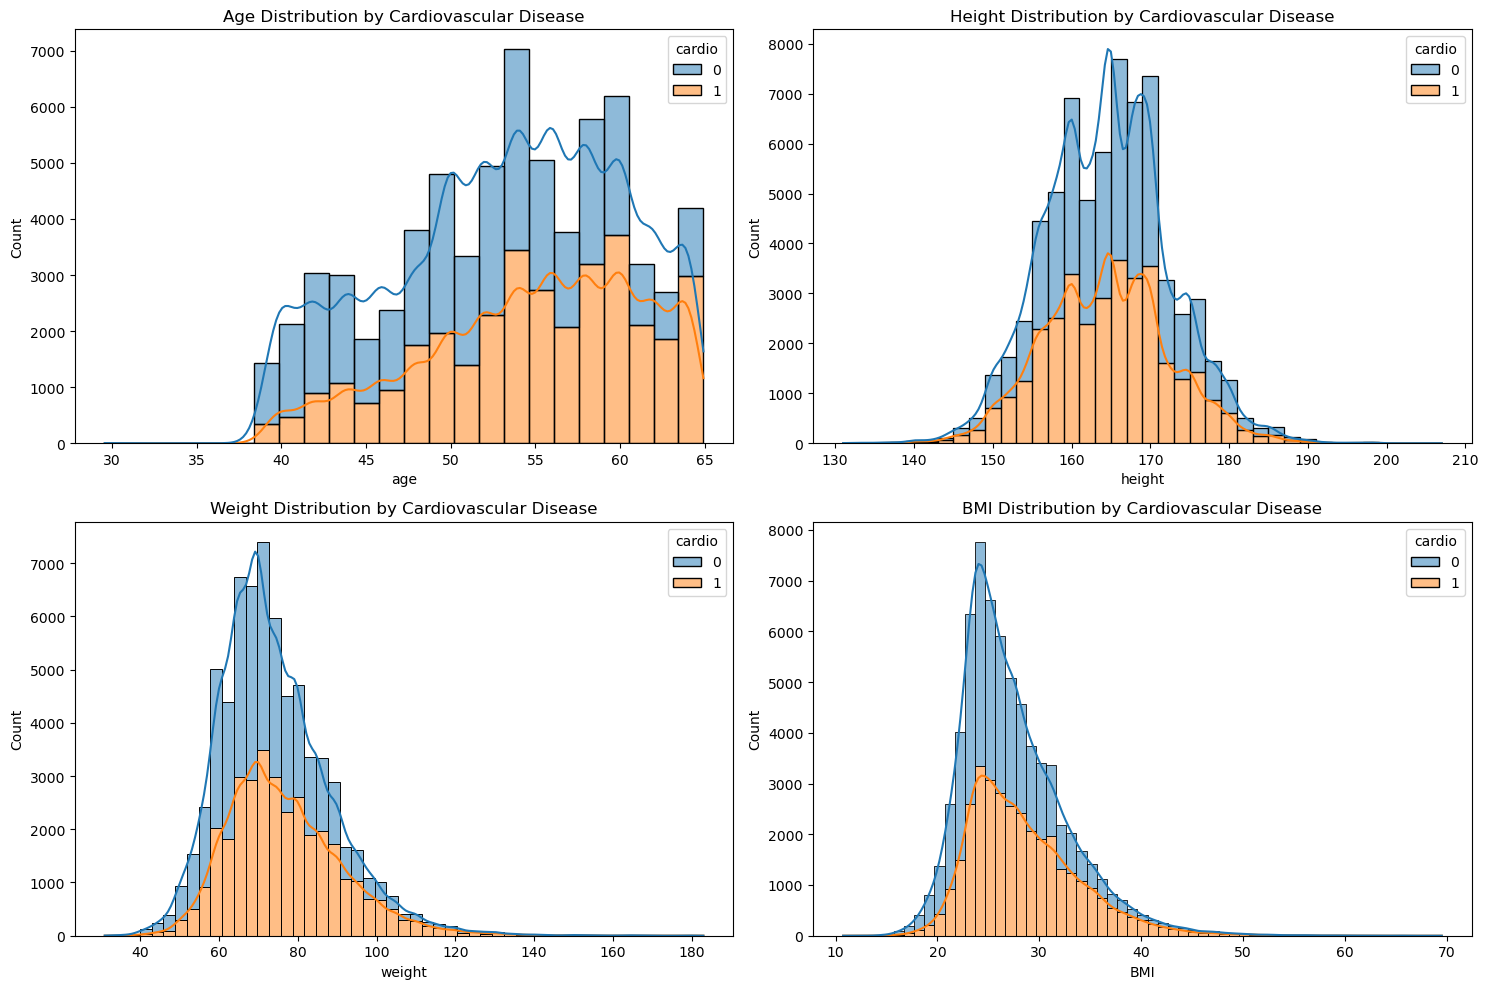

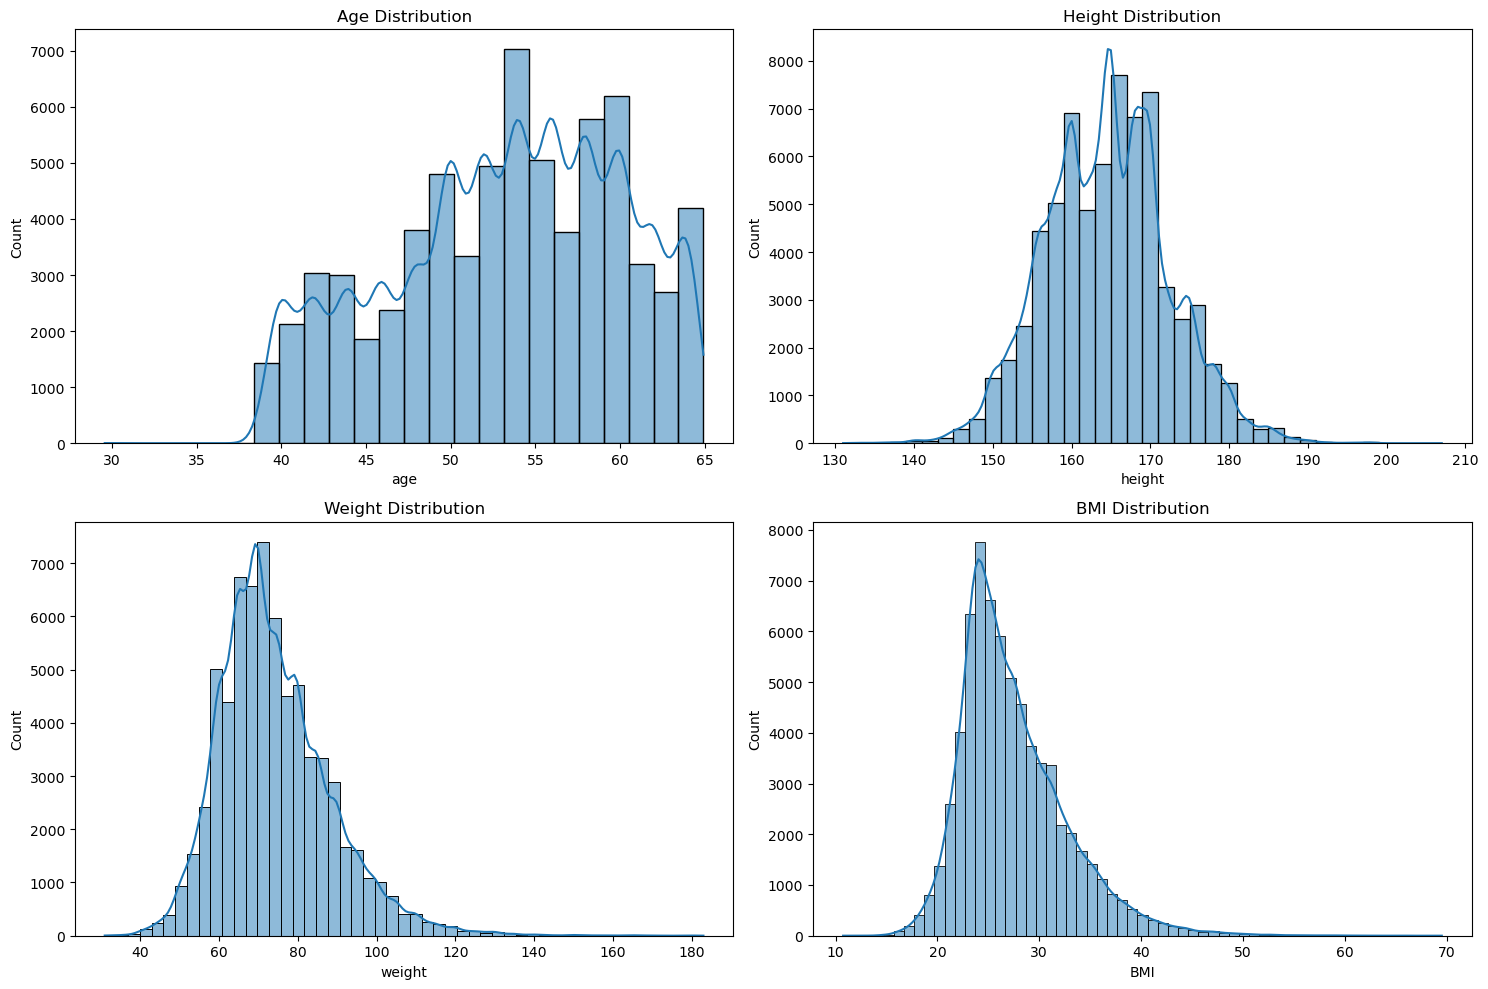

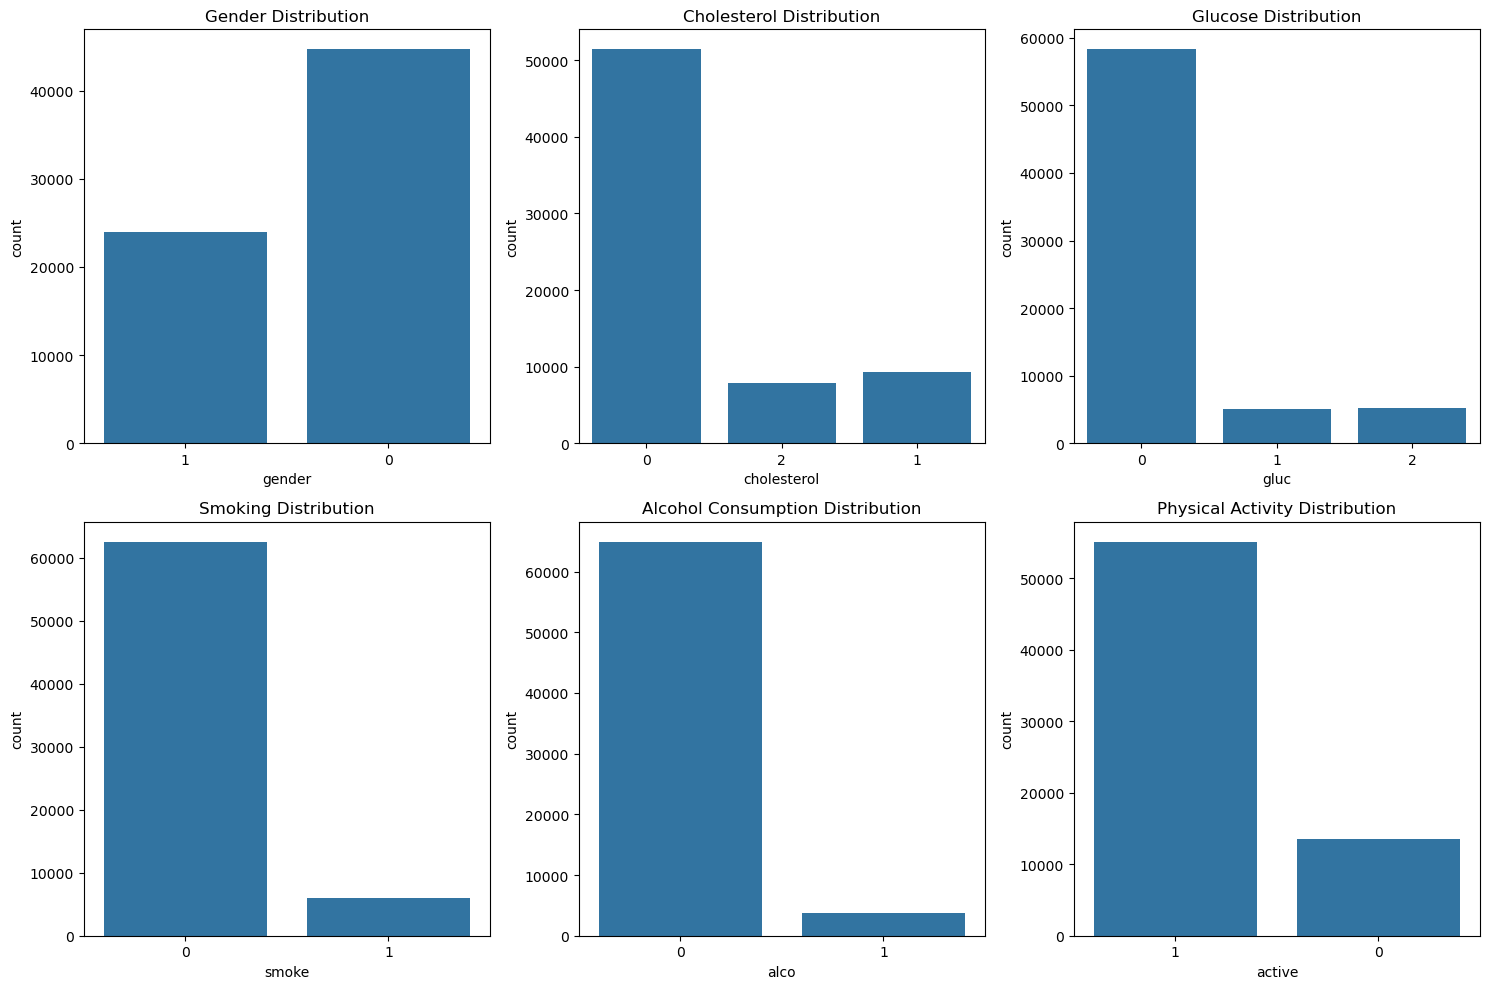

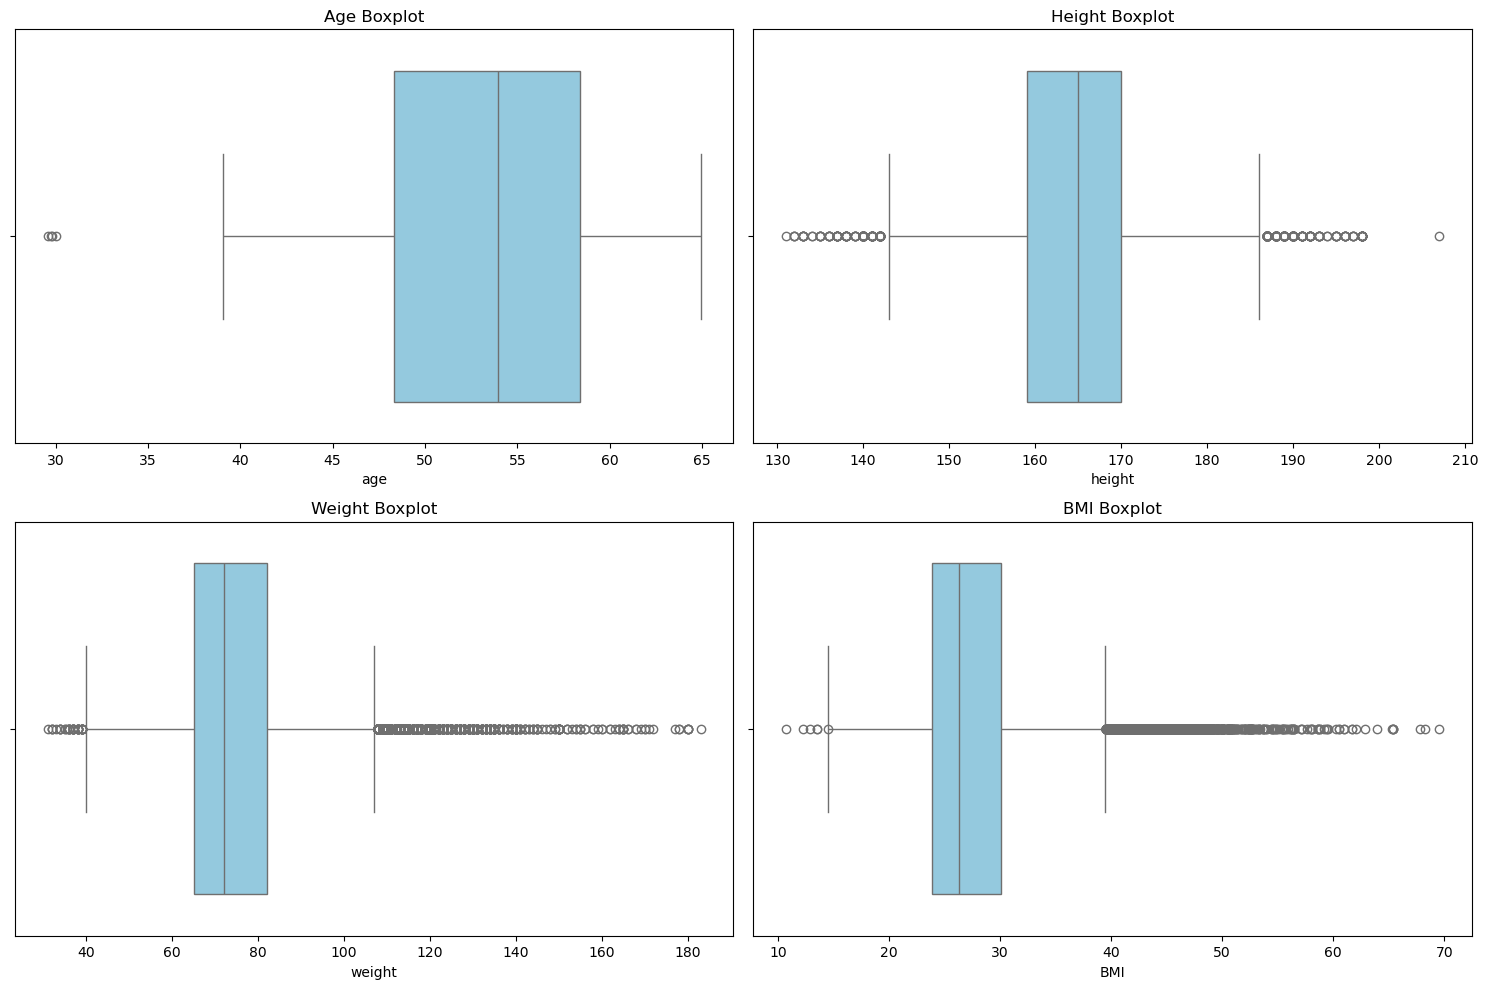

In [58]:
# Create a copy of the cleaned dataset to use for EDA
df_eda = df.copy()

####################################################
## CORRELATION MATRIX WITH HIGHLIGHTED BOTTOM ROW ##
####################################################

plt.figure(figsize=(12, 8))
# Creating a mask for the upper triangle
mask_upper = np.triu(np.ones_like(df.corr(), dtype=bool))
# Creating a mask for all but the bottom row (for highlighting)
mask_not_bottom = np.ones_like(df.corr(), dtype=bool)
mask_not_bottom[-1, :] = False  # Unmask the bottom row
# Plot the main heatmap with the upper triangle masked
sns.heatmap(df.corr(), annot=True, mask=mask_upper, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=False)
# Overlay with the bottom row highlighted
# Adjust 'highlight_cmap' to change the highlight color
highlight_cmap = sns.light_palette("seagreen", as_cmap=True)
sns.heatmap(df.corr(), annot=True, mask=mask_not_bottom, cmap=highlight_cmap, fmt=".2f", linewidths=.5, cbar=False)
plt.xticks(rotation=45)
plt.title('Enhanced Correlation Matrix with Bottom Row Highlighted')
plt.show()

#################
## OTHER PLOTS ##
#################

# Plot the distribution of the target variable according to the numerical variables
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df_eda, x='age', hue='cardio', kde=True, binwidth=1.5, ax=ax[0, 0])
ax[0, 0].set_title('Age Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='height', hue='cardio', kde=True, binwidth=2, ax=ax[0, 1])
ax[0, 1].set_title('Height Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='weight', hue='cardio', kde=True, binwidth=3, ax=ax[1, 0])
ax[1, 0].set_title('Weight Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='BMI', hue='cardio', kde=True, binwidth=1, ax=ax[1, 1])
ax[1, 1].set_title('BMI Distribution by Cardiovascular Disease')
plt.tight_layout()
plt.show()

# Plotting the distribution of the target variable according to the categorical variables
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
sns.countplot(x='gender', hue='cardio', data=df_eda,ax=ax[0, 0])
ax[0, 0].set_title('Gender Distribution\nby Cardiovascular Disease')
sns.countplot(x='cholesterol', hue='cardio', data=df_eda, ax=ax[0, 1])
ax[0, 1].set_title('Cholesterol Distribution\nby Cardiovascular Disease')
sns.countplot(x='gluc', hue='cardio', data=df_eda, ax=ax[0, 2])
ax[0, 2].set_title('Glucose Distribution\nby Cardiovascular Disease')
sns.countplot(x='smoke', hue='cardio', data=df_eda, ax=ax[1, 0])
ax[1, 0].set_title('Smoking Distribution\nby Cardiovascular Disease')
sns.countplot(x='alco', hue='cardio', data=df_eda, ax=ax[1, 1])
ax[1, 1].set_title('Alcohol Consumption Distribution\nby Cardiovascular Disease')
sns.countplot(x='active', hue='cardio', data=df_eda, ax=ax[1, 2])
ax[1, 2].set_title('Physical Activity Distribution\nby Cardiovascular Disease')
plt.tight_layout()
plt.show()

# Plot the numerical distribution like a population pyramid
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df_eda, x='age', hue='cardio', kde=True, binwidth=1.5, ax=ax[0, 0], multiple='stack')
ax[0, 0].set_title('Age Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='height', hue='cardio', kde=True, binwidth=2, ax=ax[0, 1], multiple='stack')
ax[0, 1].set_title('Height Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='weight', hue='cardio', kde=True, binwidth=3, ax=ax[1, 0], multiple='stack')
ax[1, 0].set_title('Weight Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='BMI', hue='cardio', kde=True, binwidth=1, ax=ax[1, 1], multiple='stack')
ax[1, 1].set_title('BMI Distribution by Cardiovascular Disease')
plt.tight_layout()
plt.show()

#Variables values distributions
#numerical variables
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df_eda, x='age', kde=True, binwidth=1.5, ax=ax[0, 0])
ax[0, 0].set_title('Age Distribution')
sns.histplot(df_eda, x='height', kde=True, binwidth=2, ax=ax[0, 1])
ax[0, 1].set_title('Height Distribution')
sns.histplot(df_eda, x='weight', kde=True, binwidth=3, ax=ax[1, 0])
ax[1, 0].set_title('Weight Distribution')
sns.histplot(df_eda, x='BMI', kde=True, binwidth=1, ax=ax[1, 1])
ax[1, 1].set_title('BMI Distribution')
plt.tight_layout()
plt.show()
#categorical variables
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
sns.countplot(x='gender', data=df_eda,ax=ax[0, 0])
ax[0, 0].set_title('Gender Distribution')
sns.countplot(x='cholesterol', data=df_eda, ax=ax[0, 1])
ax[0, 1].set_title('Cholesterol Distribution')
sns.countplot(x='gluc', data=df_eda, ax=ax[0, 2])
ax[0, 2].set_title('Glucose Distribution')
sns.countplot(x='smoke', data=df_eda, ax=ax[1, 0])
ax[1, 0].set_title('Smoking Distribution')
sns.countplot(x='alco', data=df_eda, ax=ax[1, 1])
ax[1, 1].set_title('Alcohol Consumption Distribution')
sns.countplot(x='active', data=df_eda, ax=ax[1, 2])
ax[1, 2].set_title('Physical Activity Distribution')
plt.tight_layout()
plt.show()

#Boxplots for numerical variables
# Variables values distributions - Numerical variables (including boxplots)
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
# Boxplots for numerical variables
sns.boxplot(x='age', data=df_eda, ax=ax[0, 0], color='skyblue')
ax[0, 0].set_title('Age Boxplot')
sns.boxplot(x='height', data=df_eda, ax=ax[0, 1], color='skyblue')
ax[0, 1].set_title('Height Boxplot')
sns.boxplot(x='weight', data=df_eda, ax=ax[1, 0], color='skyblue')
ax[1, 0].set_title('Weight Boxplot')
sns.boxplot(x='BMI', data=df_eda, ax=ax[1, 1], color='skyblue')
ax[1, 1].set_title('BMI Boxplot')
plt.tight_layout()
plt.show()

Optimization terminated successfully.
         Current function value: 0.560952
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 cardio   No. Observations:                68641
Model:                          Logit   Df Residuals:                    68628
Method:                           MLE   Df Model:                           12
Date:                Fri, 23 Feb 2024   Pseudo R-squ.:                  0.1907
Time:                        15:12:24   Log-Likelihood:                -38504.
converged:                       True   LL-Null:                       -47575.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
age             0.0516      0.001     38.033      0.000       0.049       0.054
gender         -0.0149    

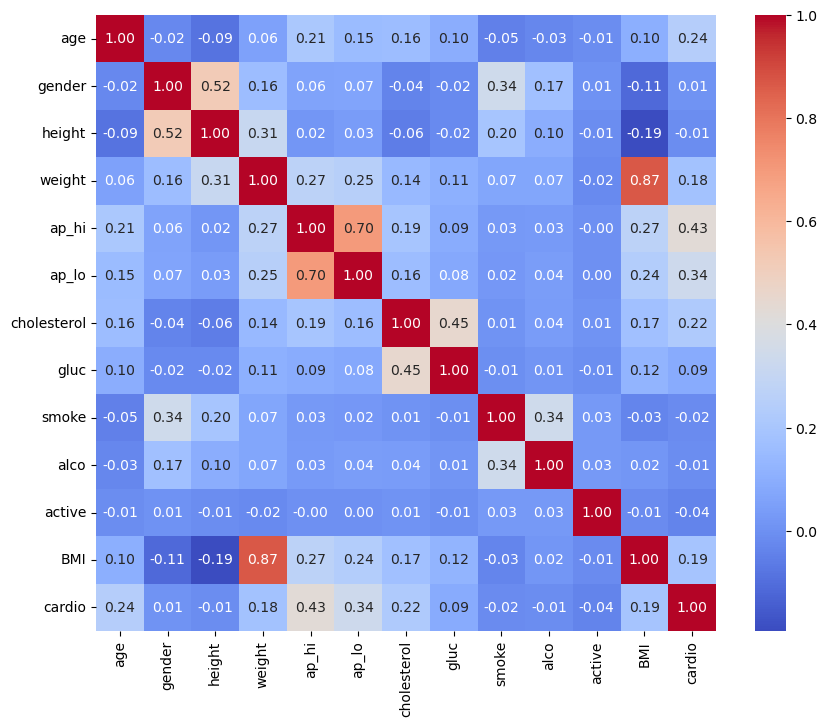

       Variable           VIF  Tolerance  Condition Index
0         const  12632.665044   0.000079       112.390680
1           age      1.073959   0.931134         0.271954
2        gender      1.511891   0.661423         0.715466
3        height     28.830999   0.034685         5.275509
4        weight    111.397725   0.008977        10.507032
5         ap_hi      2.053055   0.487079         1.026185
6         ap_lo      1.973053   0.506829         0.986435
7   cholesterol      1.321359   0.756797         0.566885
8          gluc      1.260889   0.793091         0.510773
9         smoke      1.248128   0.801200         0.498125
10         alco      1.139789   0.877355         0.373883
11       active      1.001842   0.998161         0.042919
12          BMI    104.517757   0.009568        10.174368


In [59]:
# Create a copy of the cleaned dataset to use for linear regression
df_regression = df.copy()

# Convert all categorical variables to integers
df_regression[categorical] = df_regression[categorical].astype(int)

# Get the dummies
df_with_dummies = pd.get_dummies(df_regression, drop_first=True)

# For logistic regression, statsmodels requires us to add a constant to our model
df_with_dummies['intercept'] = 1.0

# Define the model formula including all predictors
# Note: Adjust this formula based on the dummy variables created from your categorical features
formula = 'cardio ~ age + height + weight + ap_hi + ap_lo + BMI + ' + ' + '.join([f'{var}_T' for var in categorical])

# Fit the logistic regression model
model = sm.Logit(df_with_dummies['cardio'], df_with_dummies.drop(columns=['cardio'])).fit()

# Display the model's summary
print(model.summary())


# Create a copy of the cleaned dataset to use for collinearity
df_vif=df.copy()
# Convert all categorical variables to integers
df_vif[categorical] = df_vif[categorical].astype(int)
#correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_vif.corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.show()
# Assuming 'X' is the design matrix of predictor variables
X = df_vif.drop('cardio', axis=1)
X_with_constant = add_constant(X)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]

# Calculate Tolerance and Condition Index
vif_data['Tolerance'] = 1 / vif_data['VIF']
vif_data['Condition Index'] = [np.sqrt(np.abs(vif_data['VIF'][i] - 1)) for i in range(len(vif_data))]

print(vif_data[['Variable', 'VIF', 'Tolerance', 'Condition Index']])




In [60]:
#GAM w/ train-test split
# Create a copy of the cleaned dataset to use for linear regression
df_gam = df.copy()

# Convert all categorical variables to integers
df_gam[categorical] = df_gam[categorical].astype(int)

# Assuming 'df' is your DataFrame with the target variable 'cardio'
X = df_gam.drop('cardio', axis=1)
y = df_gam['cardio']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a GAM model
gam = LogisticGAM().fit(X_train, y_train)

# Make predictions on the test set
y_pred = gam.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy:.4f}')

# Print a summary of the GAM model
print(gam.summary())

Accuracy: 0.7314
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     80.2114
Link Function:                        LogitLink Log Likelihood:                                -30138.2573
Number of Samples:                        54912 AIC:                                            60436.9374
                                                AICc:                                           60437.1809
                                                UBRE:                                               3.1018
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2081
Feature Function    

/tmp/ipykernel_345516/3032370367.py:29: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [62]:
#GAM w/out train-test split
# Create a copy of the cleaned dataset to use for linear regression
df_gam = df.copy()

# Convert all categorical variables to integers
df_gam[categorical] = df_gam[categorical].astype(int)

# Assuming 'df' is your DataFrame with the target variable 'cardio'
X = df_gam.drop('cardio', axis=1)
y = df_gam['cardio']

# Fit a GAM model
gam = LogisticGAM().fit(X, y)

# Make predictions on the same dataset
y_pred = gam.predict(X)

# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y, y_pred_binary)
print(f'Accuracy: {accuracy:.4f}')

# Print a summary of the GAM model
print(gam.summary())

Accuracy: 0.7329
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     81.7387
Link Function:                        LogitLink Log Likelihood:                                -37714.3988
Number of Samples:                        68641 AIC:                                            75592.2749
                                                AICc:                                            75592.477
                                                UBRE:                                               3.1022
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2073
Feature Function    

/tmp/ipykernel_345516/3820661998.py:26: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


Mean Squared Error: 0.1890
R-squared: 0.2439


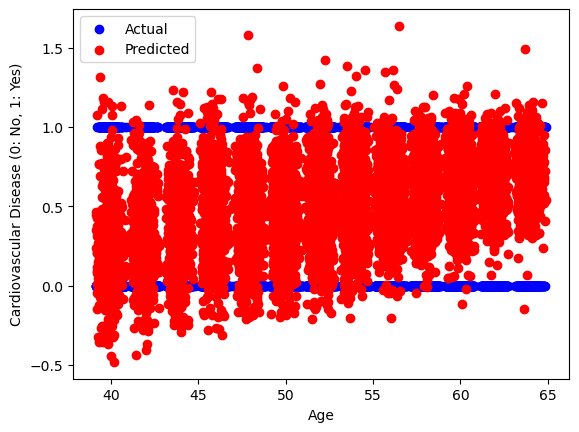

In [63]:
#Polynomial regression w/ train-test split
# Create a copy of the cleaned dataset to use for linear regression
df_poly = df.copy()

# Convert all categorical variables to integers
df_poly[categorical] = df_poly[categorical].astype(int)

# Assuming 'df' is your DataFrame with the target variable 'cardio'
X = df_poly.drop('cardio', axis=1)
y = df_poly['cardio']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the degree of the polynomial (you can adjust this)
degree = 2

# Use PolynomialFeatures to create polynomial features
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit a linear regression model with polynomial features
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_poly)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared: {r2:.4f}')

# Visualize the predictions vs. actual values
plt.scatter(X_test['age'], y_test, color='blue', label='Actual')
plt.scatter(X_test['age'], y_pred, color='red', label='Predicted')
plt.xlabel('Age')
plt.ylabel('Cardiovascular Disease (0: No, 1: Yes)')
plt.legend()
plt.show()

Mean Squared Error: 0.1883
R-squared: 0.2468


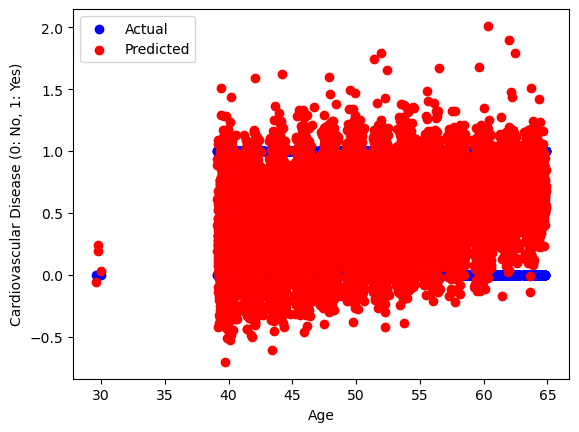

In [64]:
#Polynomial regression w/ train-test split
# Create a copy of the cleaned dataset to use for linear regression
df_poly = df.copy()

# Convert all categorical variables to integers
df_poly[categorical] = df_poly[categorical].astype(int)

# Assuming 'df' is your DataFrame with the target variable 'cardio'
X = df_poly.drop('cardio', axis=1)
y = df_poly['cardio']

# Define the polynomial degree (you can adjust this value)
degree = 2

# Use PolynomialFeatures to create polynomial features
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly.fit_transform(X)

# Fit a linear regression model with polynomial features
model = LinearRegression()
model.fit(X_poly, y)

# Make predictions on the same dataset
y_pred = model.predict(X_poly)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Print evaluation metrics
print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared: {r2:.4f}')

# Visualize the predictions vs. actual values
plt.scatter(X['age'], y, color='blue', label='Actual')
plt.scatter(X['age'], y_pred, color='red', label='Predicted')
plt.xlabel('Age')
plt.ylabel('Cardiovascular Disease (0: No, 1: Yes)')
plt.legend()
plt.show()